In [2]:
#Calculate dtw_distances
import pandas as pd
import numpy as np
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN  # 导入 DBSCAN
import seaborn as sns

shorest_traj = 9

file_path = '/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx'  
df = pd.read_excel(file_path)


# record the raw data
ID = df.iloc[0]['ID']
trajectory = 1
original_series = []
traj = []

for i in range(df.shape[0]):
    if df.iloc[i]['ID'] != ID and traj:
        if len(traj) >= shorest_traj:
            original_series.append(traj)
        ID = df.iloc[i]['ID']
        traj = []
    else:
        if df.iloc[i]['Label'] != trajectory and traj:
            if len(traj) >= shorest_traj:
                original_series.append(traj)
            trajectory = df.iloc[i]['Label']
            traj = []
    traj.append([df.iloc[i]['SpeedChange'], df.iloc[i]['AngleChange'], df.iloc[i]['Speed']])
original_series.append(traj)

#df.pop('Speed')

#normalization

df['SpeedChange'] = 2 * (df['SpeedChange'] - df['SpeedChange'].min()) / (df['SpeedChange'].max() - df['SpeedChange'].min()) - 1
df['AngleChange'] = 2 * (df['AngleChange'] - df['AngleChange'].min()) / (df['AngleChange'].max() - df['AngleChange'].min()) - 1

# cluster based on normalized data
ID = df.iloc[0]['ID']
trajectory = 1
series = []
traj = []
for i in range(df.shape[0]):
    if df.iloc[i]['ID'] != ID and traj:
        if len(traj) >= shorest_traj + 1:
            series.append(traj)
        ID = df.iloc[i]['ID']
        traj = []
    else:
        if df.iloc[i]['Label'] != trajectory and traj:
            if len(traj) >= shorest_traj + 1:
                series.append(traj)
            trajectory = df.iloc[i]['Label']
            traj = []
    if not traj:
        traj.append([ID, trajectory])
    traj.append([df.iloc[i]['SpeedChange'], df.iloc[i]['AngleChange']])
series.append(traj)

time_series_data = [np.array(ts) for ts in series]

first_columns = [ts[0] for ts in time_series_data]  # Store the first column
processed_series = [ts[1:] for ts in time_series_data]
# print(processed_series[879])

# Step 2: Compute the pairwise DTW distance matrix using only the second column
n = len(processed_series)
dtw_distances = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        distance = dtw(processed_series[i], processed_series[j])
        dtw_distances[i, j] = distance
        dtw_distances[j, i] = distance

# Convert the distance matrix to a condensed distance matrix format
dtw_distances_condensed = squareform(dtw_distances)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


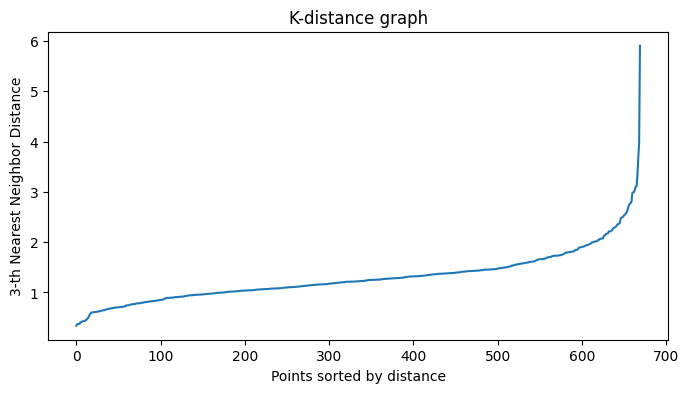

In [3]:
# Assume dtw_distances is a precomputed distance matrix
# We need to select a k value, typically k = 2 * dimension - 1
NumberofFitures = 2
k = 2 * NumberofFitures - 1  # Calculate the k nearest neighbors distance for each point

# For each point, compute the distance to its k-th nearest neighbor
k_distances = np.sort(np.partition(dtw_distances, k, axis=1)[:, k])

# Plot the k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.title('K-distance graph')
plt.show()


In [4]:
min_samples= k+1
min_samples

4

In [5]:
# Fix eps to 3
eps = 3

# Range of min_samples values
min_samples_range = range(1, 11)

# Store the Silhouette scores for different min_samples values
silhouette_scores = []

# Iterate over different min_samples values
for min_samples in min_samples_range:
    # Perform clustering using DBSCAN
    dbscan = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(dtw_distances)
    
    # Calculate the Silhouette score (excluding all samples labeled as noise)
    if len(set(cluster_labels)) > 1:  # At least two clusters are needed to compute the Silhouette score
        silhouette_avg = silhouette_score(dtw_distances, cluster_labels, metric='precomputed')
        silhouette_scores.append((min_samples, silhouette_avg))
        print(f"min_samples = {min_samples}, Silhouette score = {silhouette_avg:.4f}")
    else:
        silhouette_scores.append((min_samples, np.nan))
        print(f"min_samples = {min_samples}, Silhouette score = N/A (only one cluster or all noise)")

# Output the best min_samples value and its corresponding Silhouette score
best_min_samples, best_score = max(silhouette_scores, key=lambda x: x[1])
print(f"\nBest min_samples = {best_min_samples} with a Silhouette score of {best_score:.4f}")


min_samples = 1, Silhouette score = 0.3999
min_samples = 2, Silhouette score = 0.5395
min_samples = 3, Silhouette score = 0.5395
min_samples = 4, Silhouette score = 0.5395
min_samples = 5, Silhouette score = 0.5222
min_samples = 6, Silhouette score = 0.5222
min_samples = 7, Silhouette score = 0.5222
min_samples = 8, Silhouette score = 0.5222
min_samples = 9, Silhouette score = 0.5222
min_samples = 10, Silhouette score = 0.5222

Best min_samples = 2 with a Silhouette score of 0.5395


In [13]:
# Step 3: Perform clustering using DBSCAN
dbscan = DBSCAN(metric='precomputed', eps=3, min_samples=4)  # You can adjust the eps and min_samples parameters
cluster_labels = dbscan.fit_predict(dtw_distances)

# Step 4: Optional: Calculate the Silhouette score to evaluate clustering performance
silhouette_avg = silhouette_score(dtw_distances, cluster_labels, metric='precomputed')
print(f"Silhouette score for DBSCAN clustering: {silhouette_avg:.4f}")

# Step 5: Reattach the first column to the clustered data
clustered_dataset = []

for i in range(len(original_series)):
    length = len(original_series[i])
    clustered_data = pd.DataFrame({
        'ID': [first_columns[i][0]] * length,
        'Label': [first_columns[i][1]] * length,
        'SpeedChange': [change[0] for change in original_series[i]],
        'AngleChange': [change[1] for change in original_series[i]],
        'Speed': [change[2] for change in original_series[i]],
        'Cluster': [cluster_labels[i]] * length
    })
    clustered_dataset.append(clustered_data)

clustered_dataset = pd.concat(clustered_dataset, ignore_index=True)

# Step 6: Save the clustered data
clustered_dataset.to_csv('/Users/yangfanzhou/Desktop/1.8/ClusterResult/cluster_result_dbscan.csv', index=False)

# Step 7: Count and print the number of items in Cluster 2
cluster_2 = np.sum(cluster_labels == 2)
print(cluster_2, len(cluster_labels))


Silhouette score for DBSCAN clustering: 0.5395
0 670


In [7]:
data = pd.read_csv('/Users/yangfanzhou/Desktop/1.8/ClusterResult/cluster_result_dbscan.csv')

# Group by Cluster, ID, and Label, then count the number of unique (ID, Label) pairs in each Cluster
cluster_participant_trajectory_counts = (
    data.groupby('Cluster')
    .apply(lambda x: x.groupby(['ID', 'Label']).ngroups)
    .reset_index(name='Unique Trajectory Count')
)

# Display the result
print(cluster_participant_trajectory_counts)

   Cluster  唯一轨迹数量
0       -1       5
1        0     644


/var/folders/8t/9k64w8hn15ng50h2zwfs07tr0000gn/T/ipykernel_52694/1376290139.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.groupby(['ID', 'Label']).ngroups)


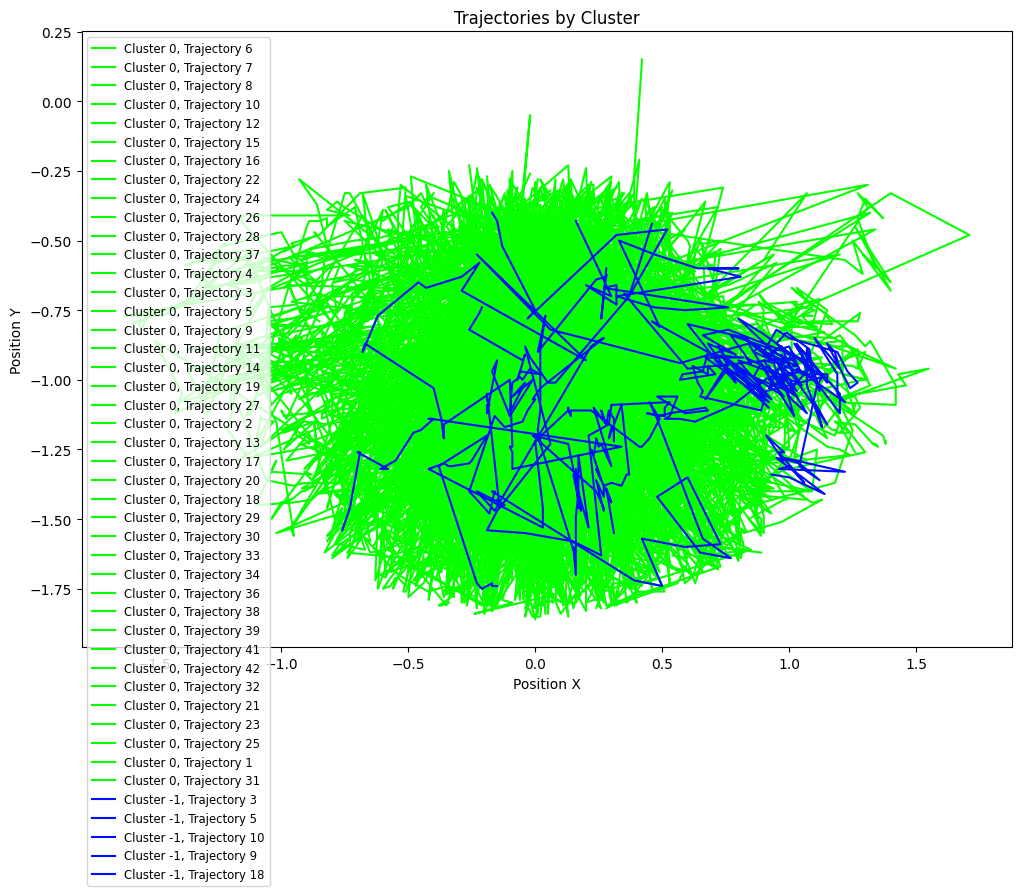

In [8]:
# This is the original dataset containing Positionx and Positiony
original_dataset = pd.read_excel('/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx')

# This is the dataset containing the cluster labels
clustered_labels = pd.read_csv('/Users/yangfanzhou/Desktop/1.8/ClusterResult/cluster_result_dbscan.csv')

# Merge the two datasets, adding the Cluster label to the original dataset
merged_data = pd.merge(original_dataset, clustered_labels, on=['ID', 'Label'])

# Use seaborn's color palette to define colors
palette = sns.color_palette("hsv", len(merged_data['Cluster'].unique()))

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each trajectory
for cluster in merged_data['Cluster'].unique():
    cluster_data = merged_data[merged_data['Cluster'] == cluster]
    
    for label in cluster_data['Label'].unique():
        trajectory_data = cluster_data[cluster_data['Label'] == label]
        plt.plot(trajectory_data['Positionx'], trajectory_data['Positiony'], 
                 label=f'Cluster {cluster}, Trajectory {label}', 
                 color=palette[cluster])

# Add legend
plt.legend(loc='best', fontsize='small')

# Set plot title and axis labels
plt.title('Trajectories by Cluster')
plt.xlabel('Position X')
plt.ylabel('Position Y')

# Show plot
plt.show()


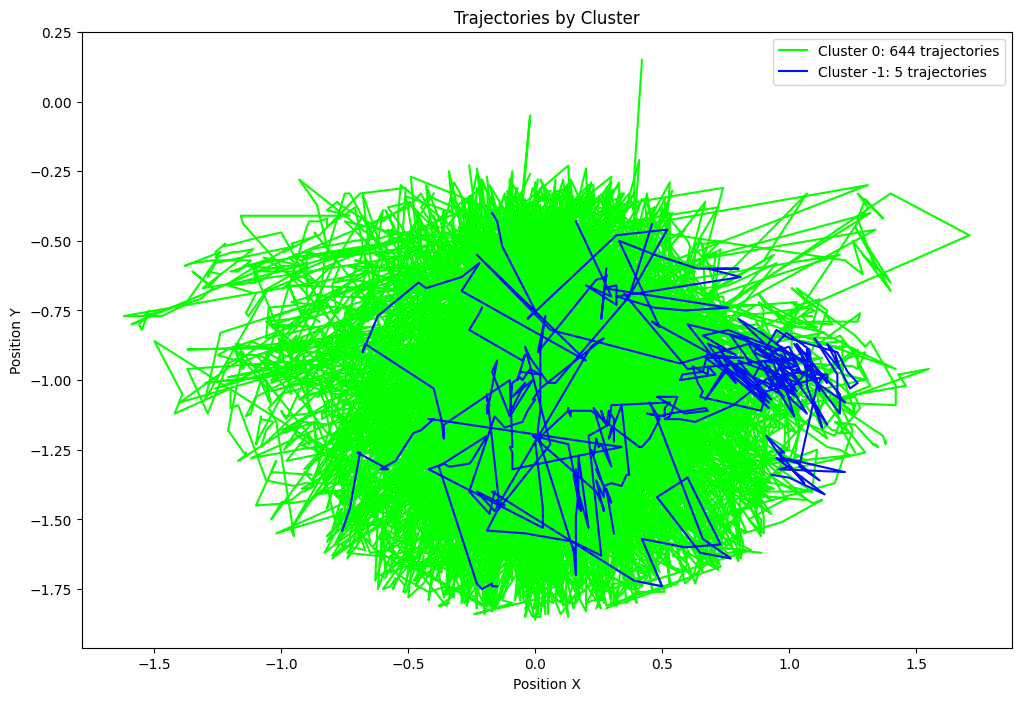

In [15]:
# This is the original dataset containing Positionx and Positiony
original_dataset = pd.read_excel('/Users/yangfanzhou/Desktop/1.8/Cluster_Data_1.86_withposition(cleaned).xlsx')

# This is the dataset containing the cluster labels
clustered_labels = pd.read_csv('/Users/yangfanzhou/Desktop/1.8/ClusterResult/cluster_result_dbscan.csv')

# Merge the clustering results with the original data
merged_df = pd.merge(df, clustered_dataset[['ID', 'Label', 'Cluster']], on=['ID', 'Label'])

# Get all unique cluster labels
unique_clusters = merged_df['Cluster'].unique()

# Use seaborn's color palette to define colors and generate enough colors
palette = sns.color_palette("hsv", len(unique_clusters))

# Create a mapping of cluster numbers to colors
cluster_color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each trajectory
for cluster in unique_clusters:
    cluster_data = merged_df[merged_df['Cluster'] == cluster]
    
    for label in cluster_data['Label'].unique():
        trajectory_data = cluster_data[cluster_data['Label'] == label]
        plt.plot(trajectory_data['Positionx'], trajectory_data['Positiony'], 
                 color=cluster_color_map[cluster])

# Manually specify the number of trajectories for each cluster
manual_legend_labels = {
    -1: 5,  # Assume Cluster -1 has x trajectories
    0: 644  # Assume Cluster 0 has y trajectories
}

# Create a custom legend
legend_labels = [f'Cluster {cluster}: {manual_legend_labels[cluster]} trajectories' for cluster in unique_clusters]
for cluster, label in zip(unique_clusters, legend_labels):
    plt.plot([], [], color=cluster_color_map[cluster], label=label)

# Add legend
plt.legend(loc='best', fontsize='medium')

# Set plot title and axis labels
plt.title('Trajectories by Cluster')
plt.xlabel('Position X')
plt.ylabel('Position Y')

# Show plot
plt.show()